# 05_A_Software_Comparison_PointCloud

In diesem Jupyter Notebook werden die Punkwolken der Softwareprodukte "Agisoft Metashape" und "Drone2Map" miteinander verglichen. 
Die Daten basieren auf Bilder der DJI Mini 3 Pro von den folgenden Aufnahmetagen:
11.03.2025 

### Import der Libraries

In [2]:
import pandas as pd
import os
from IPython.display import display, HTML
import matplotlib.cm as cm
import numpy as np
import laspy
from tqdm.notebook import tqdm
from matplotlib.ticker import FuncFormatter
import pandas as pd
import matplotlib.pyplot as plt

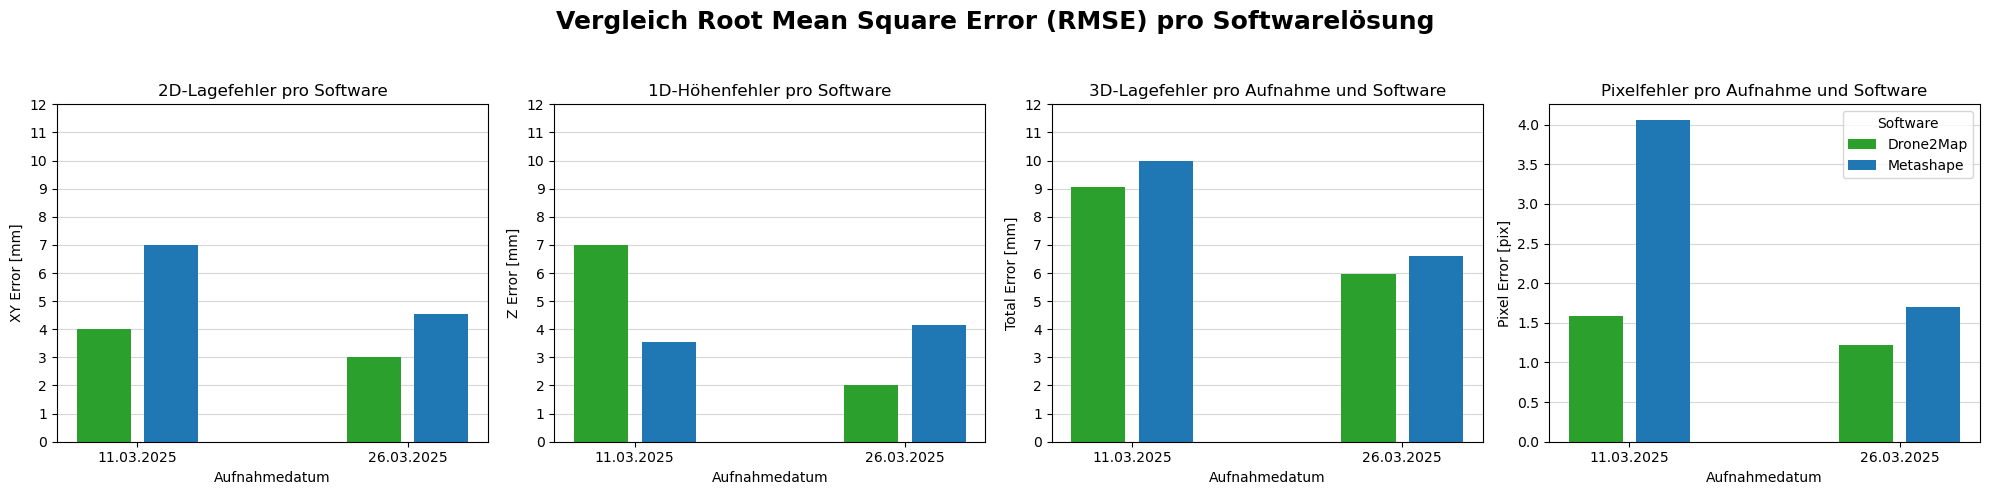

In [7]:
# CSV einlesen
df = pd.read_csv(r"C:\_Data\BTh11\BTh11_Trieblaengenwachstum\05_Software_Comparison\50_BaseData\CSV\SfM_Reports_RMSE_Values.csv")

# Farben definieren
farbe = {"Drone2Map": "#2ca02c", "Metashape": "#1f77b4"}

# Parameter
bar_width = 0.2 
bar_spacing = 0.05
category_spacing = 0.0000005

# Datum extrahieren + formatieren
df["Datum_raw"] = df["Aufnahme_ID"].str.extract(r"(2025\d{4})")[0]
df["Datum"] = pd.to_datetime(df["Datum_raw"], format="%Y%m%d").dt.strftime("%d.%m.%Y")

# Attribut-Konfiguration: (Spalte, Y-Achsen-Label, Titel)
attributes = [
    ("RMSE_X_mm", "XY Error [mm]", "2D-Lagefehler pro Software"),
    ("RMSE_Z_mm", "Z Error [mm]", "1D-Höhenfehler pro Software"),
    ("RMSE_Total_mm", "Total Error [mm]", "3D-Lagefehler pro Aufnahme und Software"),
    ("RMSE_Pixel", "Pixel Error [pix]", "Pixelfehler pro Aufnahme und Software")
]

# x-Achsen-Konfiguration
aufnahmedaten = df["Datum"].unique()
x_indices = np.arange(len(aufnahmedaten)) * (1 + category_spacing)

# Einheitliche Y-Achse für 3D-Werte
ymin, ymax = 0, 12

# Subplots
fig, axes = plt.subplots(1, len(attributes), figsize=(20, 5))


for ax, (attr, ylabel, title) in zip(axes, attributes):
    ax.set_axisbelow(True)
    
    for i, datum in enumerate(aufnahmedaten):
        for j, software in enumerate(["Drone2Map", "Metashape"]):
            value = df[(df["Datum"] == datum) & (df["Software"] == software)][attr]
            if not value.empty:
                xpos = x_indices[i] + (j - 0.5) * (bar_width + bar_spacing)
                ax.bar(xpos, value.values[0], width=bar_width, color=farbe[software])
    
    # Achsen
    ax.set_xticks(x_indices)
    ax.set_xticklabels(aufnahmedaten, rotation=0)
    ax.set_xlabel("Aufnahmedatum")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if attr != "RMSE_Pixel":
        ax.set_ylim(ymin, ymax)
        ax.set_yticks(np.arange(ymin, ymax + 1, 1))
    ax.grid(axis='y', linestyle='-', alpha=0.5)

# Legende (einmalig)
axes[3].legend(farbe.keys(), title="Software", loc="upper right")

# Gesamttitel
fig.suptitle("Vergleich Root Mean Square Error (RMSE) pro Softwarelösung", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

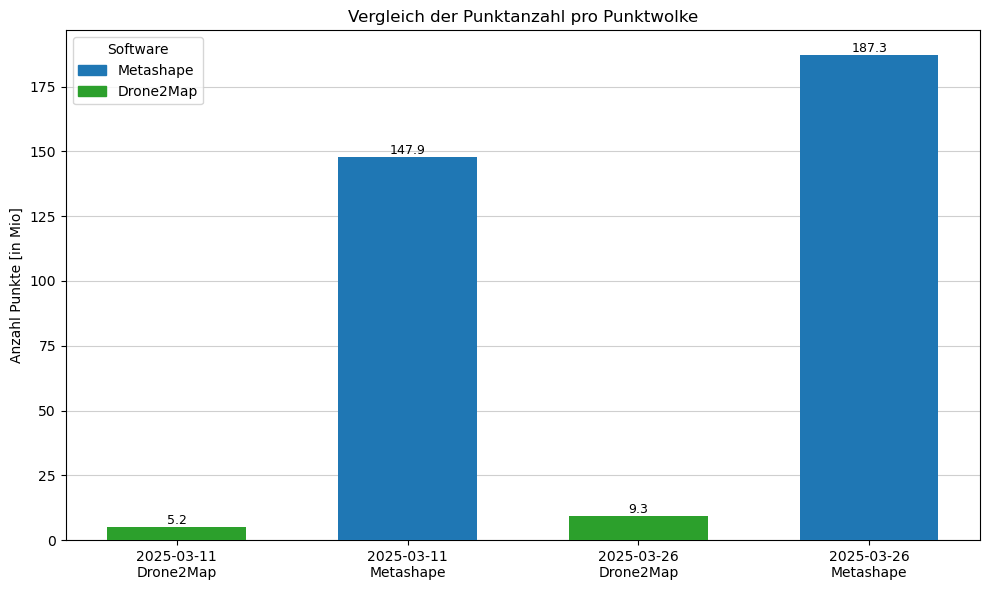

In [7]:
import os
import laspy
import matplotlib.pyplot as plt

# === Verzeichnisse
dirs = {
    "2025-03-11": r"C:\_Data\BTh11\BTh11_Trieblaengenwachstum\05_Software_Comparison\50_BaseData\PointCloud\20250311",
    "2025-03-26": r"C:\_Data\BTh11\BTh11_Trieblaengenwachstum\05_Software_Comparison\50_BaseData\PointCloud\20250326"
}

# === Datenstruktur zum Speichern
data = []

# === Punktanzahl extrahieren
for date, path in dirs.items():
    for file in sorted(os.listdir(path)):
        if file.endswith(".las"):
            try:
                full_path = os.path.join(path, file)
                las = laspy.read(full_path)
                n_points = len(las.points)

                # Software aus Dateiname extrahieren
                if "Metashape" in file:
                    software = "Metashape"
                elif "Drone2Map" in file:
                    software = "Drone2Map"
                else:
                    software = "Unbekannt"

                data.append({
                    "date": date,
                    "software": software,
                    "filename": file,
                    "n_points_mio": n_points / 1_000_000
                })

            except Exception as e:
                print(f"Fehler bei Datei {file}: {e}")

# === Plot vorbereiten
labels = [f"{d['date']}\n{d['software']}" for d in data]
values = [d["n_points_mio"] for d in data]
colors = ["#1f77b4" if d["software"] == "Metashape" else "#2ca02c" for d in data]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors, width=0.6, zorder=100)

# Beschriftung
plt.ylabel("Anzahl Punkte [in Mio]")
plt.title("Vergleich der Punktanzahl pro Punktwolke")
plt.grid(axis='y', linestyle='-', alpha=0.6)

# Werte beschriften
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1.0, f"{height:.1f}", ha='center', fontsize=9, zorder=101)

# Legende
plt.legend(handles=[
    plt.Rectangle((0, 0), 1, 1, color="#1f77b4", label="Metashape"),
    plt.Rectangle((0, 0), 1, 1, color="#2ca02c", label="Drone2Map")
], title="Software")

plt.tight_layout()
plt.show()
